In [32]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  

In [33]:
data = pd.read_csv(r"C:\Users\thent\OneDrive\Desktop\datdaset\bank.csv")

In [102]:
data.sample(10)

,age,job,marital,education,balance,housing,loan,contact,campaign,pdays,previous,poutcome,y
204,29,blue-collar,single,tertiary,455,no,no,telephone,1,-1,0,unknown,yes
84,37,management,married,tertiary,1315,no,no,cellular,1,-1,0,unknown,yes
1646,38,technician,single,tertiary,2273,yes,no,cellular,1,-1,0,unknown,no
106,37,blue-collar,married,secondary,427,yes,yes,unknown,3,-1,0,unknown,no
3294,40,management,married,tertiary,1217,yes,yes,cellular,1,-1,0,unknown,no
1614,40,admin.,single,secondary,2378,yes,no,unknown,1,-1,0,unknown,no
2795,36,technician,divorced,tertiary,1174,yes,no,cellular,2,-1,0,unknown,no
4282,34,admin.,divorced,secondary,-251,no,no,cellular,1,-1,0,unknown,yes
3408,38,management,single,tertiary,8669,yes,no,telephone,3,150,6,failure,no
4237,33,technician,single,secondary,2085,no,no,cellular,2,-1,0,unknown,yes


In [35]:
selected_columns = [
    'age', 'job', 'marital', 'education',
    'balance', 'housing', 'loan', 'contact',
    'campaign', 'pdays', 'previous', 'poutcome'
]

In [36]:
data = data[selected_columns + ['y']]

In [49]:
data.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan',
       'contact', 'campaign', 'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [37]:
numeric_feature = X.select_dtypes(include= ['int64', 'float64']).columns.tolist()
categorical_feature = X.select_dtypes(include =['object']).columns.tolist()

In [38]:
# Encoding 
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_feature),
    ('cat', categorical_pipeline, categorical_feature)
])


In [52]:
# #
# from sklearn.ensemble import RandomForestClassifier
# model_pipeline = ImbPipeline(steps=[
#     ('preprocessing', preprocessor),
#     ('smote', SMOTE(random_state=42)),
#     ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
# ])

In [92]:
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', BorderlineSMOTE(sampling_strategy=0.5)),
    ('classifier', XGBClassifier(scale_pos_weight=807/98))
])

In [93]:
data.shape

(4521, 13)

In [94]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
contact      0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [95]:
X = data.drop('y', axis = 'columns')
Y = data['y'].map({'yes': 1, 'no': 0})

In [96]:
data['y'].value_counts()

y
no     4000
yes     521
Name: count, dtype: int64

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [98]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [99]:
y_pred_prob = model_pipeline.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_prob > 0.3).astype(int)


In [100]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_adjusted))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.72      0.81       807
           1       0.19      0.53      0.28        98

    accuracy                           0.70       905
   macro avg       0.56      0.63      0.55       905
weighted avg       0.85      0.70      0.75       905



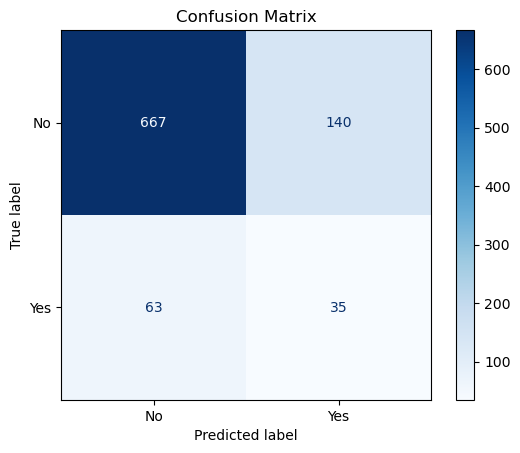

In [101]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()